# Video 1: Language Models as Classifiers
## "The Cat Sat" - Classification in Action

This notebook demonstrates the fundamental concept that language models are **massive classifiers** that predict the next token from tens of thousands of possibilities.

### Key Concepts:
1. Every prediction is a classification problem across ~128,000 tokens
2. Context dramatically changes the probability distribution
3. Different choices lead to completely different paths
4. The model doesn't "know" the answer - it computes probabilities for ALL tokens


In [1]:
# Install required packages
!pip install transformers torch matplotlib ipywidgets nbformat anywidget


In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style for matplotlib visualizations
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


## Load a Language Model

We'll use LLama3.2 1B for demonstration.


In [3]:
print("Loading Language Model...")
print("=" * 50)

model_name = "meta-llama/Llama-3.2-1B"
print(f"Model: {model_name}")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model.eval()

vocab_size = len(tokenizer)
print(f"Model loaded successfully!")
print(f"Vocabulary size: {vocab_size:,} tokens")
print(f"\nThis means EVERY prediction is a classification among {vocab_size:,} possible classes!")


Loading Language Model...
Model: meta-llama/Llama-3.2-1B
Model loaded successfully!
Vocabulary size: 128,256 tokens

This means EVERY prediction is a classification among 128,256 possible classes!


## Helper Methods

In [4]:
def get_next_token_probabilities(context: str, top_k: int = 10) -> Tuple[List[str], List[float], torch.Tensor]:
    """
    Get probability distribution for the next token given a context.

    Returns:
        tokens: List of top-k token strings
        probs: List of top-k probabilities
        all_probs: Full probability distribution (for all vocab tokens)
    """
    inputs = tokenizer(context, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits[0, -1, :]  # Get logits for last position
        probs = F.softmax(logits, dim=-1)  # Convert to probabilities

    # Get top-k predictions
    top_probs, top_indices = torch.topk(probs, top_k)

    tokens = [tokenizer.decode([idx]) for idx in top_indices]
    probs_list = top_probs.tolist()

    return tokens, probs_list, probs


def get_lowest_token_probabilities(context: str, bottom_k: int = 10) -> Tuple[List[str], List[float]]:
    """
    Get the lowest probability tokens for the next token given a context.

    Returns:
        tokens: List of bottom-k token strings
        probs: List of bottom-k probabilities
    """
    inputs = tokenizer(context, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits[0, -1, :]  # Get logits for last position
        probs = F.softmax(logits, dim=-1)  # Convert to probabilities

    # Get bottom-k predictions (lowest probabilities)
    bottom_probs, bottom_indices = torch.topk(probs, bottom_k, largest=False)

    tokens = [tokenizer.decode([idx]) for idx in bottom_indices]
    probs_list = bottom_probs.tolist()

    return tokens, probs_list


def visualize_probabilities(context: str, top_k: int = 10, title: str = None):
    """
    Visualize the probability distribution for next token prediction.
    """
    tokens, probs, _ = get_next_token_probabilities(context, top_k)

    # Create horizontal bar chart
    fig, ax = plt.subplots(figsize=(12, 6))

    y_pos = np.arange(len(tokens))
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(tokens)))

    bars = ax.barh(y_pos, probs, color=colors)

    # Customize
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f'"{token}"' for token in tokens])
    ax.invert_yaxis()  # Highest probability at top
    ax.set_xlabel('Probability', fontsize=12)
    ax.set_title(title or f'Next Token Predictions for: "{context}"',
                 fontsize=14, fontweight='bold', pad=20)

    # Add probability values on bars
    for i, (bar, prob) in enumerate(zip(bars, probs)):
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{prob:.4f} ({prob*100:.1f}%)',
                ha='left', va='center', fontsize=10)

    ax.set_xlim(0, max(probs) * 1.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"\n📊 Classification Summary:")
    print(f"Context: '{context}'")
    print(f"Vocabulary size: {vocab_size:,} tokens")
    print(f"Top prediction: '{tokens[0]}' with probability {probs[0]:.4f}")
    print(f"\n⚠️  Remember: The model computed probabilities for ALL {vocab_size:,} tokens!")


def visualize_highest_and_lowest_probabilities(context: str, top_k: int = 10, bottom_k: int = 10):
    """
    Visualize both highest and lowest probability tokens side by side.
    """
    plt.close('all')
    # Get highest probabilities
    top_tokens, top_probs, _ = get_next_token_probabilities(context, top_k)

    # Get lowest probabilities
    bottom_tokens, bottom_probs = get_lowest_token_probabilities(context, bottom_k)

    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot highest probabilities
    y_pos = np.arange(len(top_tokens))
    colors_high = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_tokens)))
    bars1 = ax1.barh(y_pos, top_probs, color=colors_high)

    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([f'"{token}"' for token in top_tokens])
    ax1.invert_yaxis()
    ax1.set_xlabel('Probability', fontsize=12)
    ax1.set_title(f'HIGHEST Probabilities\nfor: "{context}"',
                  fontsize=14, fontweight='bold', pad=20)

    # Add probability values on bars
    for i, (bar, prob) in enumerate(zip(bars1, top_probs)):
        width = bar.get_width()
        ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{prob:.4f}',
                ha='left', va='center', fontsize=10)

    ax1.set_xlim(0, max(top_probs) * 1.3)

    # Plot lowest probabilities
    y_pos = np.arange(len(bottom_tokens))
    colors_low = plt.cm.plasma(np.linspace(0.3, 0.9, len(bottom_tokens)))
    bars2 = ax2.barh(y_pos, bottom_probs, color=colors_low)

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([f'"{token}"' for token in bottom_tokens])
    ax2.invert_yaxis()
    ax2.set_xlabel('Probability', fontsize=12)
    ax2.set_title(f'LOWEST Probabilities\nfor: "{context}"',
                  fontsize=14, fontweight='bold', pad=20)

    # Add probability values on bars (scientific notation for very small numbers)
    for i, (bar, prob) in enumerate(zip(bars2, bottom_probs)):
        width = bar.get_width()
        ax2.text(width + width * 0.1, bar.get_y() + bar.get_height()/2,
                f'{prob:.2e}',
                ha='left', va='center', fontsize=10)

    ax2.set_xlim(0, max(bottom_probs) * 1.5)

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"\n📊 Complete Classification Summary:")
    print(f"Context: '{context}'")
    print(f"Vocabulary size: {vocab_size:,} tokens")
    print(f"\n🔝 Highest: '{top_tokens[0]}' with probability {top_probs[0]:.6f}")
    print(f"🔻 Lowest: '{bottom_tokens[0]}' with probability {bottom_probs[0]:.2e}")
    print(f"\n⚠️  The model computed probabilities for ALL {vocab_size:,} tokens!")
    print(f"   Even the most unlikely tokens still got a probability!")


## The Classic Example - "The cat sat on the..."

Let's see what the model predicts. Notice how it considers EVERYTHING in the vocabulary, including absurd options.


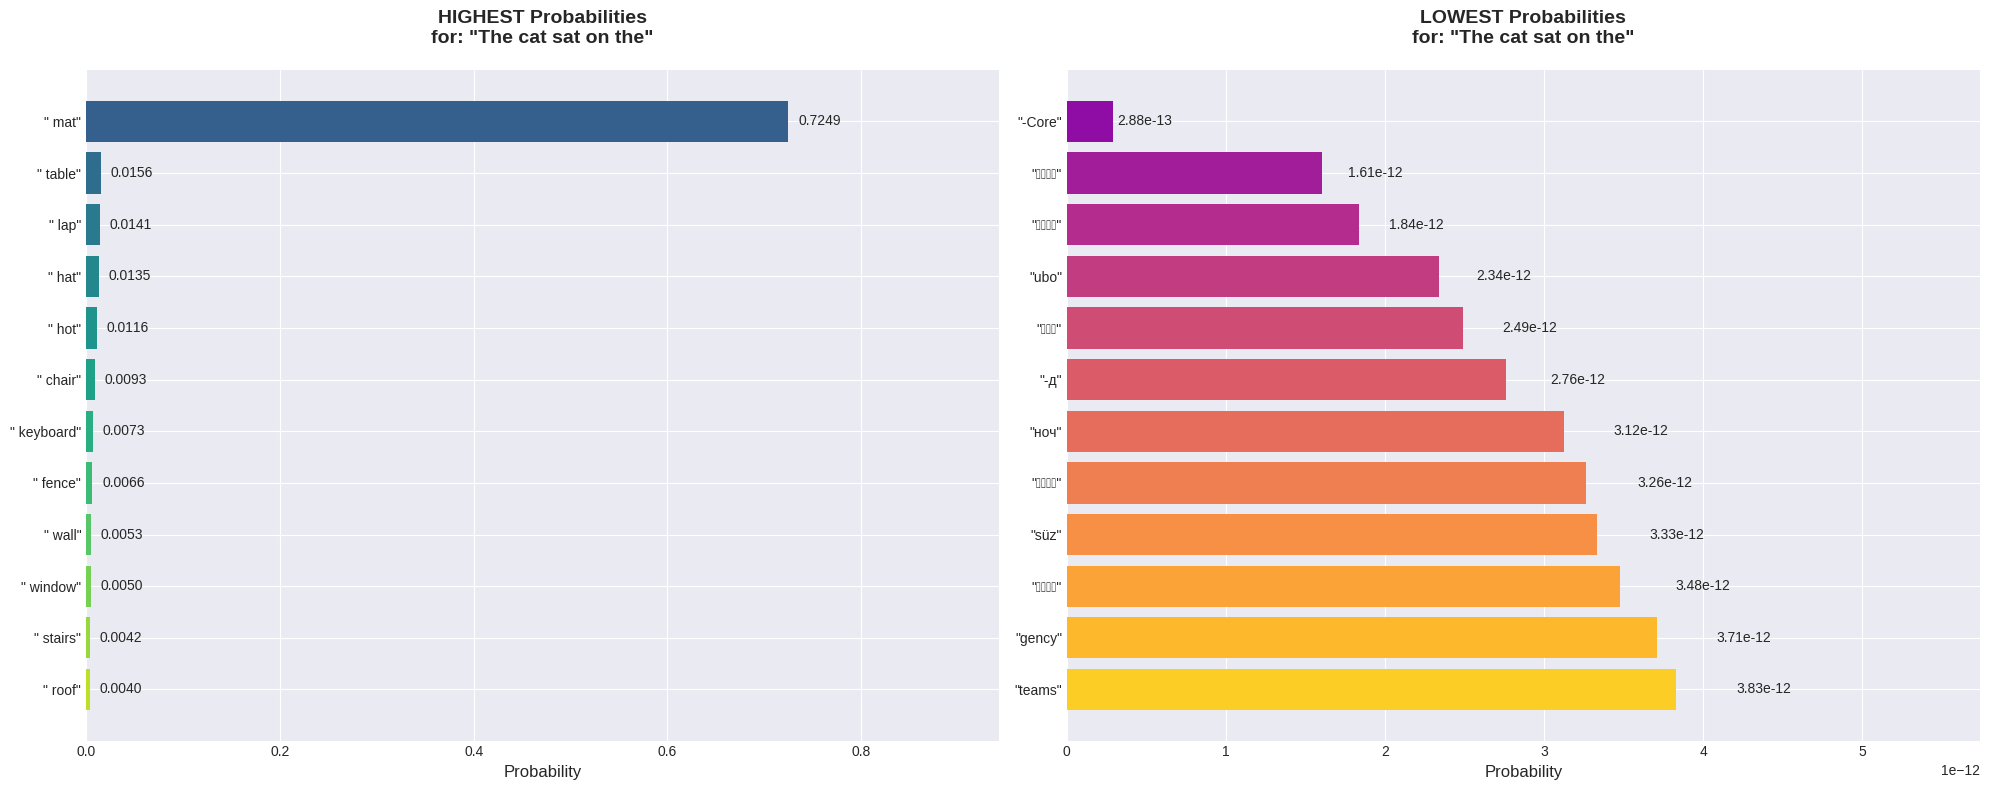


📊 Complete Classification Summary:
Context: 'The cat sat on the'
Vocabulary size: 128,256 tokens

🔝 Highest: ' mat' with probability 0.724893
🔻 Lowest: '-Core' with probability 2.88e-13

⚠️  The model computed probabilities for ALL 128,256 tokens!
   Even the most unlikely tokens still got a probability!


In [5]:
context = "The cat sat on the mat"
visualize_highest_and_lowest_probabilities(context, top_k=12, bottom_k=12)


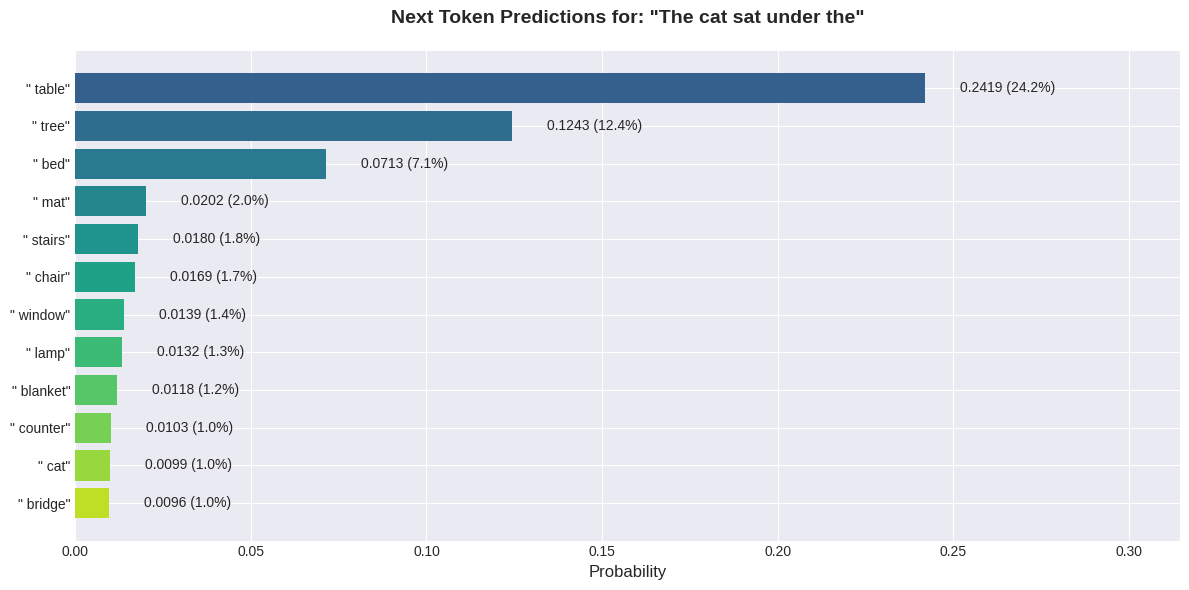


📊 Classification Summary:
Context: 'The cat sat under the'
Vocabulary size: 128,256 tokens
Top prediction: ' table' with probability 0.2419

⚠️  Remember: The model computed probabilities for ALL 128,256 tokens!


In [6]:
context = "The cat sat under the"
visualize_probabilities(context, top_k=12)


### 💡 Key Insight

The model just made a **128,000-way classification decision**!

Even though we only see the top 12, the model computed probabilities for:
- "mat" ✅ (makes sense)
- "floor" ✅ (makes sense)
- "mitochondria" ❌ (extremely low probability, but still computed!)
- "quantum" ❌ (extremely low probability, but still computed!)
- Every other token in the vocabulary...

This is why we call it a **classification task**.


## Side-by-Side Comparison

Let's visualize multiple branches side-by-side to really see the divergence.


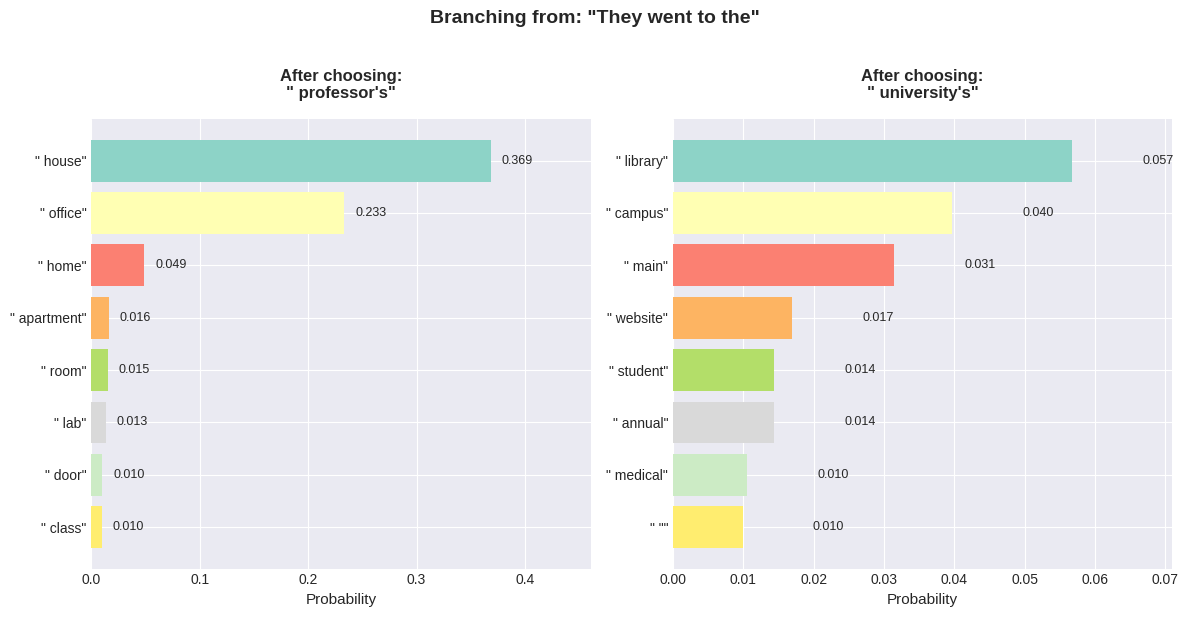


💡 Key Observation:
   Each branch leads to a completely different probability landscape!
   This is why the same model can generate diverse outputs.


In [7]:


def compare_branches_side_by_side(base_context: str, alternatives: List[str], top_k: int = 8):
    """
    Create side-by-side comparison of different branching paths.
    """
    plt.close('all')
    n_alternatives = len(alternatives)
    fig, axes = plt.subplots(1, n_alternatives, figsize=(6*n_alternatives, 6))

    if n_alternatives == 1:
        axes = [axes]

    for idx, (ax, alt_token) in enumerate(zip(axes, alternatives)):
        context = base_context + alt_token
        tokens, probs, _ = get_next_token_probabilities(context, top_k)

        y_pos = np.arange(len(tokens))
        colors = plt.cm.Set3(np.linspace(0, 1, len(tokens)))

        bars = ax.barh(y_pos, probs, color=colors)

        ax.set_yticks(y_pos)
        ax.set_yticklabels([f'"{token}"' for token in tokens])
        ax.invert_yaxis()
        ax.set_xlabel('Probability', fontsize=11)
        ax.set_title(f'After choosing:\n"{alt_token}"',
                     fontsize=12, fontweight='bold', pad=15)

        # Add probability values
        for bar, prob in zip(bars, probs):
            width = bar.get_width()
            ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{prob:.3f}',
                    ha='left', va='center', fontsize=9)

        ax.set_xlim(0, max(probs) * 1.25)

    plt.suptitle(f'Branching from: "{base_context}"',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    print("\n💡 Key Observation:")
    print("   Each branch leads to a completely different probability landscape!")
    print("   This is why the same model can generate diverse outputs.")


compare_branches_side_by_side("They went to the", [" professor's", " university's"])


## 🎮 Interactive Explorer!

Now the fun part - an **interactive widget** where you can type any text and see the model's predictions update in real-time!


In [8]:
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np

def create_classification_plot(context):
    """Create matplotlib plot for next token predictions"""

    if not context or not context.strip():
        # Return empty figure if no input
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.text(0.5, 0.5, '⚠️ Please enter some text!',
                ha='center', va='center', fontsize=14)
        ax.axis('off')
        return fig

    try:
        # Get predictions
        tokens, probs, _ = get_next_token_probabilities(context, top_k=20)

        # Create figure
        fig, ax = plt.subplots(figsize=(12, 10))
        probs = np.array(probs)

        # Create horizontal bar chart
        colors = plt.cm.viridis(probs / probs.max())
        bars = ax.barh(range(len(tokens)), probs, color=colors)

        # Set y-axis labels with token names
        ax.set_yticks(range(len(tokens)))
        ax.set_yticklabels([f'"{token}"' for token in tokens])
        ax.invert_yaxis()  # Highest probability at top

        # Add value labels on bars
        for i, (bar, prob) in enumerate(zip(bars, probs)):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   f' {prob:.4f} ({prob*100:.2f}%)',
                   va='center', fontsize=9)

        # Labels and title
        ax.set_xlabel('Probability', fontsize=12, fontweight='bold')
        ax.set_ylabel('Token', fontsize=12, fontweight='bold')
        ax.set_title(f'Next Token Predictions\nContext: "{context}"',
                    fontsize=14, fontweight='bold', pad=20)

        # Add grid
        ax.grid(axis='x', alpha=0.3, linestyle='--')

        # Add info box
        info_text = f'Classification Scale:\nChoosing from {vocab_size:,} possible tokens!\n\n'
        info_text += f'Top prediction: "{tokens[0]}" ({probs[0]:.4f})'

        ax.text(0.98, 0.02, info_text,
               transform=ax.transAxes,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
               verticalalignment='bottom',
               horizontalalignment='right',
               fontsize=9)

        plt.tight_layout()
        return fig

    except Exception as e:
        # Return error figure
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.text(0.5, 0.5, f'❌ Error: {str(e)}',
                ha='center', va='center', fontsize=12, color='red')
        ax.axis('off')
        return fig

# Create Gradio interface
with gr.Blocks(title="Next Token Classifier") as demo:
    gr.Markdown("# 🔍 Next Token Classifier")
    gr.Markdown("Type or paste text below. The visualization will update automatically after you stop typing for 1 second.")

    with gr.Row():
        text_input = gr.Textbox(
            label="Context",
            placeholder="Type your text here... (e.g., 'The cat sat on the')",
            lines=5,
            value="The cat sat on the"
        )

    plot_output = gr.Plot(label="Next Token Predictions")

    # Trigger plot update when user stops typing for 1 second
    text_input.change(
        fn=create_classification_plot,
        inputs=text_input,
        outputs=plot_output,
        trigger_mode="always_last",  # Only process the last event
        concurrency_limit=1
    )

    # Also trigger on load
    demo.load(
        fn=create_classification_plot,
        inputs=text_input,
        outputs=plot_output
    )

# Launch the interface
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1b81e93a1c23633fb5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 🎬 Summary: What We've Learned

### Core Concepts from Video 1:

1. **Language models are classifiers**
   - Every prediction is a classification across thousands of tokens
   - The model computes probabilities for EVERY token, even absurd ones

2. **Context is everything**
   - The same model produces completely different distributions based on context
   - Small changes in context → dramatic changes in probabilities

3. **Branching paths**
   - Choosing different tokens leads to different probability landscapes
   - One choice affects all subsequent predictions

4. **Scale matters**
   - 50,000-way classification at EVERY position
   - For 50 generated tokens → 50,000^50 possible sequences (incomprehensibly large)

5. **Interactive exploration**
   - You can now explore how ANY text affects model predictions
   - The interactive widget lets you see the classification in real-time